In [1]:
import pandas as pd
import numpy as np
import os
import pickle

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as func

In [3]:
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [5]:
import matplotlib.pyplot as plt

# Data location

In [6]:
data_path = "data/clean_data.csv"
save_directory = "weights/logistic_regression_weights"
accuracies_file_path = "tests/tests_pkl/logistic_regression/LogisticRegression_accuracies.pkl"

if not os.path.isdir(save_directory):
    os.mkdir(save_directory)

# Set seed

In [7]:
SEED = 42

# Load data

In [8]:
df = pd.read_csv(data_path)

In [9]:
df.shape

(11627, 39)

In [10]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

In [11]:
df.iloc[:, 1: 23].columns

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
       'LDLC'],
      dtype='object')

In [12]:
df.iloc[:, 23: 31].columns

Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
       'HYPERTEN'],
      dtype='object')

In [13]:
print(df.iloc[:, 1: 23].shape[1], df.iloc[:, 23: 31].shape[1])

22 8


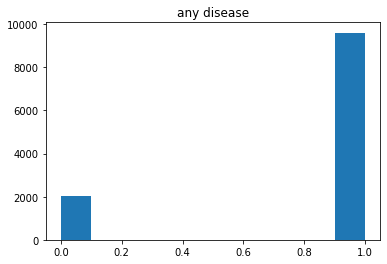

In [14]:
data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)
amax_label = np.amax(data[:, 23:31], axis=1)
hist,bins = np.histogram(amax_label) 

plt.hist(amax_label, bins = bins) 
plt.title("any disease") 
plt.show()

In [15]:
df

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448.0,1.0,195.0,39.0,106.0,70.0,0.0,0.0,26.970,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
1,2448.0,1.0,209.0,52.0,121.0,66.0,0.0,0.0,27.794,0.0,...,1.0,0.0,8766.0,6438.0,6438.0,6438.0,8766.0,6438.0,8766.0,8766.0
2,6238.0,0.0,250.0,46.0,121.0,81.0,0.0,0.0,28.730,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
3,6238.0,0.0,260.0,52.0,105.0,70.0,0.0,0.0,29.430,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
4,6238.0,0.0,237.0,58.0,108.0,66.0,0.0,0.0,28.500,0.0,...,0.0,0.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11622,9998212.0,1.0,173.0,46.0,126.0,82.0,0.0,0.0,19.170,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11623,9998212.0,1.0,153.0,52.0,143.0,89.0,0.0,0.0,25.740,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,0.0
11624,9999312.0,0.0,196.0,39.0,133.0,86.0,1.0,30.0,20.910,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0
11625,9999312.0,0.0,240.0,46.0,138.0,79.0,1.0,20.0,26.390,0.0,...,0.0,1.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,8766.0,4201.0


# DataSet

In [16]:
class HeartDeseaseDataset(Dataset): 
    
    def __init__(self, path, any_disease=False, label_indexes=[30, 31], split_indexes=[1, 23, 23, 31]):        
        self.data = np.loadtxt(path, delimiter=",", dtype=np.float32, skiprows=1)
        self.x = torch.from_numpy(self.data[:, split_indexes[0]:split_indexes[1]])
        
        if any_disease:
            self.y = torch.from_numpy(np.amax(self.data[:, split_indexes[2]:split_indexes[3]], axis=1))
        else:
            self.y = torch.from_numpy(pd.get_dummies(self.data[:, label_indexes[0]:label_indexes[1]].flatten()).to_numpy(dtype=np.float32))
        
        self.minMax = torch.from_numpy(compute_min_max(data_path, split_indexes[0], split_indexes[1]))
        self.len = len(self.data)
        self.class_weights = compute_weight_class(self.y)

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        inputs = torch.sub(self.x[idx], self.minMax[0])/ torch.sub(self.minMax[1],self.minMax[0])
        return inputs, self.y[idx]

# DataLoader

In [17]:
def create_dataloaders(dataset, batch_size, display_proportions=False):
    lengths = [round(len(dataset) * split) for split in [TRAIN_SPLIT, VALIDATION_SPLIT, TEST_SPLIT]]
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=lengths, generator=torch.Generator().manual_seed(SEED))
    
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        prefetch_factor=1,
        persistent_workers=False,
        pin_memory=True
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )
    
    if display_proportions:
        print(f'Total dataset: {len(train_dataloader) + len(val_dataloader) + len(test_dataloader)}, '
                f'train dataset: {len(train_dataloader)}, val dataset: {len(val_dataloader)}, test_dataset: {len(test_dataloader)}')
    return train_dataloader, val_dataloader, test_dataloader

# Trainer

In [18]:
class Trainer:
    def __init__(self, model, class_weights, loss='dl', lr=0.5, save_directory= "regression_logistic_weights", label_name = ""):
    
        possible_loss = {'dl' : DiceLoss(), 'nllloss' : nn.NLLLoss(weight=class_weights, reduction='mean'),
                         'cross' : nn.CrossEntropyLoss(weight=class_weights), 'mse' : nn.MSELoss(reduction='mean'),
                         'BCEloss' : nn.BCELoss(), 'BCElogits' : nn.BCEWithLogitsLoss(weight=class_weights)}
        
        self.model = model
        
        self.criterion = possible_loss[loss]
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.6, patience=2, cooldown=2)
        
        self.history = {'lr': [], 'loss': [], 'acc':[], 'val_loss': [], 'val_acc':[]}
        self.max_val_acc = float('-inf')
        self.save_dir = save_directory
        self.label_name = label_name
        
    def fit(self, train_dataloader, val_dataloader, nb_epochs):
        print(f'==== Training {self.label_name} ====\n')
        
        for epoch in range(nb_epochs):
            print(f'Epoch {epoch + 1} / {nb_epochs}')
            train_loss = val_loss = train_acc = val_acc = 0.0
            
            self.model.train()
            pbar = tf.keras.utils.Progbar(target=len(train_dataloader))
            
            for i, batch in enumerate(train_dataloader):
                inputs, labels = batch

                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                
                # Forward pass to get output/logits
                output = self.model(inputs)

                # Calculate Loss: softmax --> cross entropy loss
                loss = self.criterion(output, labels)
                train_loss += loss
                train_acc += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(output.detach().numpy()[0]) else 0

                # Getting gradients w.r.t. parameters
                loss.backward()

                pbar.update(i + 1, values=
                            [
                                ("loss", train_loss.item()/(i + 1)),
                                ("acc", train_acc/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])
                
                # Updating parameters
                self.optimizer.step()
                
            
            print('Validation')
            
            self.model.eval()
            pbar = tf.keras.utils.Progbar(target=len(val_dataloader))
            
            with torch.no_grad():
                for i, batch in enumerate(val_dataloader):
                    inputs, labels = batch
                    output = self.model(inputs)
                    
                    val_loss += loss
                    val_acc += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(output.detach().numpy()[0]) else 0
                    
                    pbar.update(i + 1, values=
                            [
                                ("loss", val_loss.item()/(i + 1)),
                                ("acc", val_acc/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])
                    
            train_loss = train_loss / len(train_dataloader)
            train_acc = train_acc / len(train_dataloader)
            
            val_loss = val_loss / len(val_dataloader)
            val_acc = val_acc / len(val_dataloader)
            
            lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.scheduler.step(val_loss)
            
            self.history['lr'].append(lr)
            self.history['loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            
            if val_acc > self.max_val_acc:
                print(f'Model saved. Acc updated: {self.max_val_acc:.3f} -> {val_acc:.3f}')
                self.max_val_acc = val_acc
                torch.save(self.model.state_dict(), f'{self.save_dir}/regression_logistice_{self.label_name}.pt')
            
    def evaluate(self, test_dataloader, display=True):
        print(f'==== Evaluate {self.label_name} ====\n')
        correct = total_loss = total = 0.0
        #iterator = 0
        self.model.eval()
        with torch.no_grad():       
            # Iterate through test dataset
            for i, (inputs, labels) in enumerate(test_dataloader):

                pred = self.model(inputs)

                loss = self.criterion(pred, labels)
                total_loss += loss
                    
                # Total correct predictions
                correct += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(pred.detach().numpy()[0]) else 0
                #iterator += 1

            total_accuracy = 100 * correct / len(test_dataloader)
            
            if display: 
                print('Iteration: {}. Loss: {}. Accuracy: {}. total loss: {}.'.format(len(test_dataloader), loss.item(), total_accuracy, total_loss))
            
            return total_accuracy
        
    def display_history(self, accuracy=True, loss=False):
        if loss:
            plt.figure(figsize=(6,6))
            plt.plot(self.history['loss'], label="Loss")
            plt.plot(self.history['val_loss'], label="Validation loss")
            plt.ylabel('Loss', fontsize=10)
            plt.xlabel('Epochs', fontsize=10)
            plt.legend()
            plt.show()

        if accuracy:
            plt.figure(figsize=(6,6))
            plt.plot(self.history['acc'], label="Accuracy")
            plt.plot(self.history['val_acc'], label="Validation accuracy")
            plt.ylabel('Accuracy', fontsize=10)
            plt.xlabel('Epochs', fontsize=10)
            plt.legend()
            plt.show()
     

# Loss

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# The logistic regession function

In [20]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        #out = self.final_activation(out)
        return out

# Unbalanced classes

In [21]:
def compute_weight_class(labels):
    unique, counts = np.unique(np.argmax(labels.numpy(), axis=1), return_counts=True)
    class_weights = torch.tensor([(class_counts / labels.shape[0]) for class_counts in counts],dtype=torch.float32)
    return class_weights

# Min max compute

In [22]:
def compute_min_max(data_path, first_col_index=1, last_col_index=23):
    data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)[:, first_col_index:last_col_index]
    return np.stack((data.min(axis=0), data.max(axis=0)))

# Prepare the data

In [23]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.21
TRAIN_SPLIT = 1 - TEST_SPLIT - VALIDATION_SPLIT

# Data verification

In [24]:
heart_dataset = HeartDeseaseDataset(data_path, any_disease=False)
train_dataloader_verif, val_dataloader_verif, test_dataloader_verif = create_dataloaders(heart_dataset, batch_size=1)

In [25]:
participant = next(iter(train_dataloader_verif))
print('input ==>\n', participant[0])
print('label ==>\n', participant[1])

input ==>
 tensor([[1.0000, 0.1935, 0.6531, 0.2749, 0.4583, 0.0000, 0.0000, 0.2178, 0.0000,
         0.0000, 0.1366, 0.0820, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.8896, 1.0000, 0.1229, 0.2532]])
label ==>
 tensor([[0., 1.]])


# function a ranger

In [26]:
def prediction_analyse(dataloader, trainer):
    accuracy = trainer.evaluate(dataloader, display=False)
    print("accuracy", accuracy)
    
    all_predictions = np.array([])
    all_labels = np.array([])
    
    for i, (inputs, labels) in enumerate(dataloader):
        pred = trainer.model(inputs)
        pred = np.where(pred[0].detach().numpy() < 0., 0, 1)
        pred = np.argmax(pred)
        
        label = np.argmax(labels[0].detach().numpy())

        all_predictions = np.append(all_predictions, pred)
        all_labels = np.append(all_labels, label)

    cm = confusion_matrix(all_labels, all_predictions)


    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot()
    plt.show()

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatif

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    #positive predictive value
    PPV = TP / (TP + FP)
    #negative predictive value
    NPV = TN / (TN + FN)


    print(f'sensitivity : {sensitivity}, specificity : {specificity}, PPV : {PPV}, NPV : {NPV}')
    return accuracy

In [27]:
def prediction_analyse_labels(columns_names, trainers, batch_size=1):
    accuracies = {}
    
    for i, column in enumerate(df.iloc[:, 23: 31].columns):
        
        if not column in columns_names:
            continue
            
        for trainer in trainers:
            if column == trainer.label_name:
                dataset = HeartDeseaseDataset(data_path, any_disease=False, label_indexes=[23 + i, 24 + i])
                _, _, test_dataloader = create_dataloaders(dataset, batch_size=batch_size)
            
                accuracies[column] = prediction_analyse(test_dataloader, trainer)
                print("\n\n")
                break
    return accuracies

In [28]:
def save_accuracies_pkl(pkl_filepath, accuracies):
    accuracies_file = open(pkl_filepath, "wb")
    pickle.dump(accuracies, accuracies_file)
    accuracies_file.close()

# Train

In [29]:
def train_labels(columns_names, data_path, nb_epochs=3, batch_size=1, display_history=True):
    trainers = []

    for i, column in enumerate(df.iloc[:, 23: 31].columns):
        if not column in columns_names:
            continue

        dataset = HeartDeseaseDataset(data_path, any_disease=False, label_indexes=[23 + i, 24 + i])
        train_dataloader, val_dataloader, test_dataloader = create_dataloaders(dataset, batch_size)

        model = LogisticRegression(22,2)
        
        trainer = Trainer(model, dataset.class_weights, loss='BCElogits', lr=0.05, label_name=column)
        trainer.fit(train_dataloader, val_dataloader, nb_epochs=nb_epochs)
        trainers.append(trainer)
        
        if display_history:
            trainer.display_history()

        print("\n\n")
    return trainers

==== Training DEATH ====

Epoch 1 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2887 - acc: 0.7008 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 968us/step - loss: 0.2680 - acc: 0.7590 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.759
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2549 - acc: 0.7550 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 934us/step - loss: 0.0490 - acc: 0.7639 - lr: 0.05000s - loss: 0.0490 - acc: 0.7640 - lr: 
Model saved. Acc updated: 0.759 -> 0.763


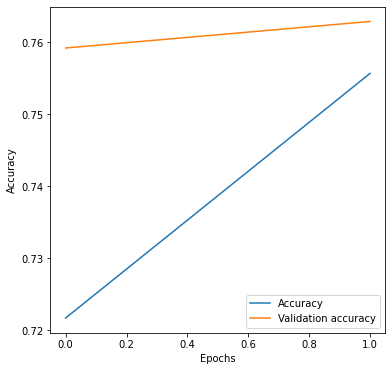




==== Training ANGINA ====

Epoch 1 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2040 - acc: 0.8362 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 913us/step - loss: 0.0652 - acc: 0.8835 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.890
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1752 - acc: 0.8856 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 918us/step - loss: 0.0472 - acc: 0.8963 - lr: 0.0500
Model saved. Acc updated: 0.890 -> 0.890


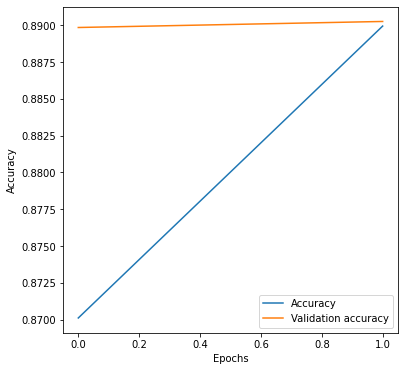




==== Training HOSPMI ====

Epoch 1 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1672 - acc: 0.8911 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 937us/step - loss: 0.0944 - acc: 0.8930 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.904
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1412 - acc: 0.9017 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 945us/step - loss: 0.0233 - acc: 0.9061 - lr: 0.0500
Model saved. Acc updated: 0.904 -> 0.914


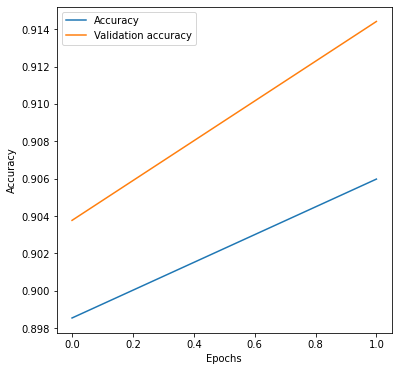




==== Training MI_FCHD ====

Epoch 1 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2095 - acc: 0.8473 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 946us/step - loss: 0.0782 - acc: 0.8695 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.869
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1878 - acc: 0.8596 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 944us/step - loss: 0.0302 - acc: 0.8729 - lr: 0.0500
Model saved. Acc updated: 0.869 -> 0.871


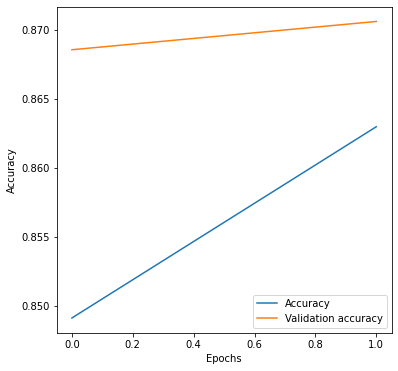




==== Training ANYCHD ====

Epoch 1 / 2
6860/6860 [==============================] - 10s 1ms/step - loss: 0.2710 - acc: 0.7499 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 954us/step - loss: 0.1002 - acc: 0.7954 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.805
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2283 - acc: 0.8031 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 922us/step - loss: 0.1327 - acc: 0.8048 - lr: 0.0500


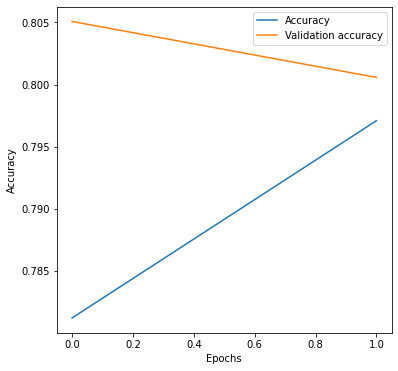




==== Training STROKE ====

Epoch 1 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1672 - acc: 0.8922 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 0.0494 - acc: 0.9054 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.914
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.1434 - acc: 0.8993 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 893us/step - loss: 0.0268 - acc: 0.9204 - lr: 0.0500
Model saved. Acc updated: 0.914 -> 0.916


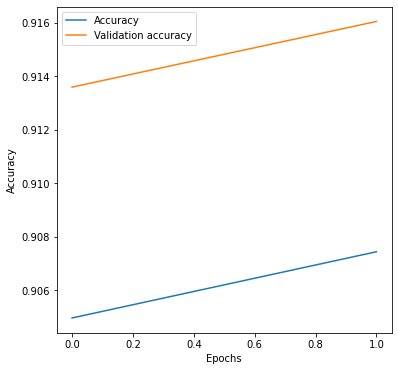




==== Training CVD ====

Epoch 1 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2683 - acc: 0.7402 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 896us/step - loss: 0.1195 - acc: 0.7914 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.784
Epoch 2 / 2
6860/6860 [==============================] - 8s 1ms/step - loss: 0.2373 - acc: 0.7890 - lr: 0.0500
Validation
2442/2442 [==============================] - 3s 1ms/step - loss: 1.0916 - acc: 0.8013 - lr: 0.0500
Model saved. Acc updated: 0.784 -> 0.790


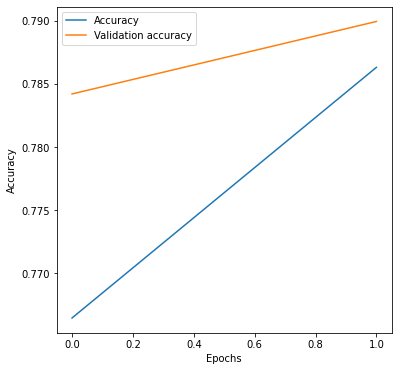




==== Training HYPERTEN ====

Epoch 1 / 2
6860/6860 [==============================] - 9s 1ms/step - loss: 0.2241 - acc: 0.7550 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 930us/step - loss: 0.2947 - acc: 0.7769 - lr: 0.0500
Model saved. Acc updated: -inf -> 0.772
Epoch 2 / 2
6860/6860 [==============================] - 9s 1ms/step - loss: 0.1773 - acc: 0.7989 - lr: 0.0500
Validation
2442/2442 [==============================] - 2s 966us/step - loss: 0.2411 - acc: 0.7968 - lr: 0.0500
Model saved. Acc updated: 0.772 -> 0.797


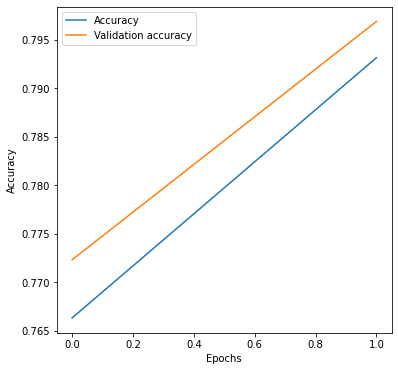

In [30]:
trainers = train_labels(df.iloc[:, 23: 31].columns, data_path, 2)

# Test

In [31]:
df.iloc[:, 23: 31].columns

Index(['DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE', 'CVD',
       'HYPERTEN'],
      dtype='object')

==== Evaluate DEATH ====

accuracy 77.84946236559139


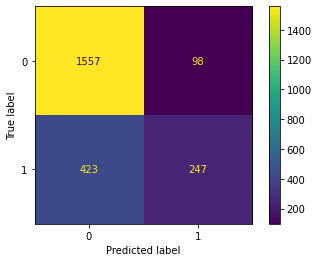

sensitivity : 0.3686567164179104, specificity : 0.9407854984894259, PPV : 0.7159420289855073, NPV : 0.7863636363636364



==== Evaluate ANGINA ====

accuracy 88.04301075268818


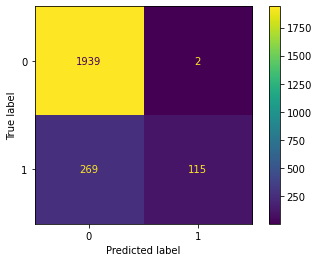

sensitivity : 0.2994791666666667, specificity : 0.9989696032972695, PPV : 0.9829059829059829, NPV : 0.8781702898550725



==== Evaluate HOSPMI ====

accuracy 92.12903225806451


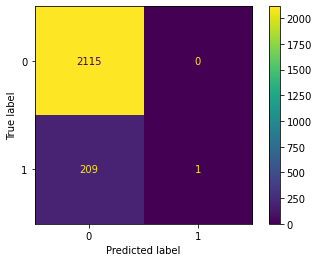

sensitivity : 0.004761904761904762, specificity : 1.0, PPV : 1.0, NPV : 0.9100688468158348



==== Evaluate MI_FCHD ====

accuracy 88.04301075268818


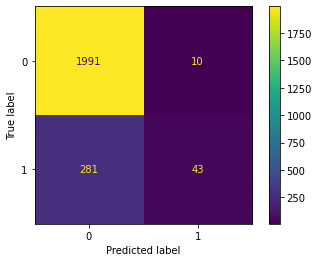

sensitivity : 0.13271604938271606, specificity : 0.9950024987506247, PPV : 0.8113207547169812, NPV : 0.8763204225352113



==== Evaluate ANYCHD ====

accuracy 79.78494623655914


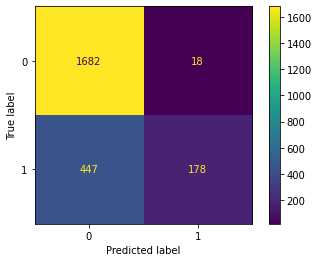

sensitivity : 0.2848, specificity : 0.9894117647058823, PPV : 0.9081632653061225, NPV : 0.7900422733677783



==== Evaluate STROKE ====

accuracy 91.01075268817205


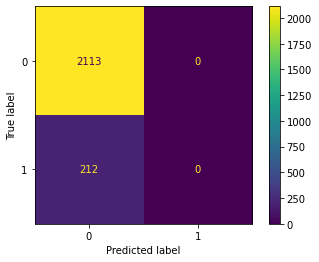

sensitivity : 0.0, specificity : 1.0, PPV : nan, NPV : 0.9088172043010753



==== Evaluate CVD ====



<ipython-input-26-0ea47c1cdf41>:33: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)


accuracy 80.21505376344086


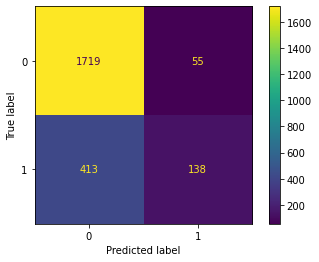

sensitivity : 0.25045372050816694, specificity : 0.9689966178128523, PPV : 0.7150259067357513, NPV : 0.8062851782363978



==== Evaluate HYPERTEN ====

accuracy 80.51612903225806


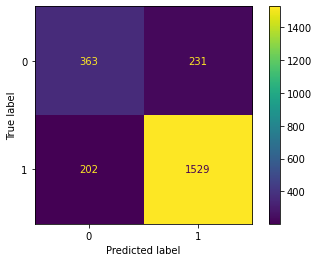

sensitivity : 0.8833044482957828, specificity : 0.6111111111111112, PPV : 0.86875, NPV : 0.6424778761061947





In [32]:
accuracies = prediction_analyse_labels(df.iloc[:, 23: 31].columns, trainers, )

In [33]:
save_accuracies_pkl(accuracies_file_path, accuracies)